In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['X_train.csv', 'sample_submission.csv', 'X_test.csv', 'y_train.csv']


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [5]:
train_data = pd.read_csv("../input/X_train.csv")

In [6]:
print(train_data.shape)
train_data.head()

(487680, 13)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [7]:
train_data['series_id'].nunique()

3810

In [8]:
train_labels = pd.read_csv("../input/y_train.csv")

In [9]:
print(train_labels.shape)
print(train_labels['surface'].nunique())
train_labels.head()

(3810, 3)
9


,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


So, there are 3810 actual tested cases on 9 different categories of surfaces. We can see below that there is no missing data.

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487680 entries, 0 to 487679
Data columns (total 13 columns):
row_id                   487680 non-null object
series_id                487680 non-null int64
measurement_number       487680 non-null int64
orientation_X            487680 non-null float64
orientation_Y            487680 non-null float64
orientation_Z            487680 non-null float64
orientation_W            487680 non-null float64
angular_velocity_X       487680 non-null float64
angular_velocity_Y       487680 non-null float64
angular_velocity_Z       487680 non-null float64
linear_acceleration_X    487680 non-null float64
linear_acceleration_Y    487680 non-null float64
linear_acceleration_Z    487680 non-null float64
dtypes: float64(10), int64(2), object(1)
memory usage: 48.4+ MB


# EDA

In [13]:
def get_range(data_list):
    
    return max(data_list)-min(data_list)

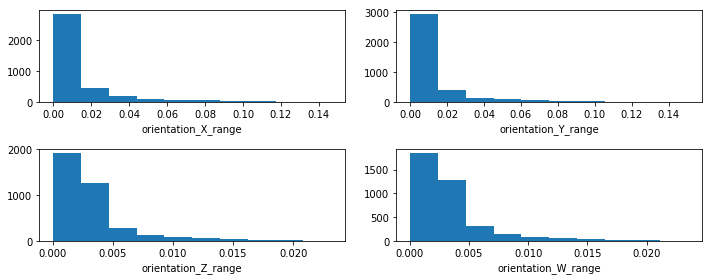

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(221)
plt.hist(train_data.groupby('series_id')['orientation_X'].apply(get_range))
plt.xlabel('orientation_X_range')
plt.subplot(222)
plt.hist(train_data.groupby('series_id')['orientation_Y'].apply(get_range))
plt.xlabel('orientation_Y_range')
plt.subplot(223)
plt.hist(train_data.groupby('series_id')['orientation_Z'].apply(get_range))
plt.xlabel('orientation_Z_range')
plt.subplot(224)
plt.hist(train_data.groupby('series_id')['orientation_W'].apply(get_range))
plt.xlabel('orientation_W_range')
plt.tight_layout()

As we can see from the above histograms, the values of 'orientation' in a given series do not vary much (as the 'range' values are very small here).

In [15]:
def plot_feature_variations(series_n_data, series_number, surface_type):
    
    plt.figure(figsize=(15,4))

    plt.subplot(231)
    plt.plot(series_n_data['measurement_number'],series_n_data['angular_velocity_X'])
    plt.xlabel('measurement_number')
    plt.ylabel('angular_velocity_X')

    plt.subplot(232)
    plt.plot(series_n_data['measurement_number'],series_n_data['angular_velocity_Y'])
    plt.xlabel('measurement_number')
    plt.ylabel('angular_velocity_Y')

    plt.subplot(233)
    plt.plot(series_n_data['measurement_number'],series_n_data['angular_velocity_Z'])
    plt.xlabel('measurement_number')
    plt.ylabel('angular_velocity_Z')

    plt.subplot(234)
    plt.plot(series_n_data['measurement_number'],series_n_data['linear_acceleration_X'])
    plt.xlabel('measurement_number')
    plt.ylabel('linear_acceleration_X')

    plt.subplot(235)
    plt.plot(series_n_data['measurement_number'],series_n_data['linear_acceleration_Y'])
    plt.xlabel('measurement_number')
    plt.ylabel('linear_acceleration_Y')

    plt.subplot(236)
    plt.plot(series_n_data['measurement_number'],series_n_data['linear_acceleration_Z'])
    plt.xlabel('measurement_number')
    plt.ylabel('linear_acceleration_Z')

    plt.tight_layout()

Feature Variations for Surface Type fine_concrete
Feature Variations for Surface Type concrete
Feature Variations for Surface Type soft_tiles


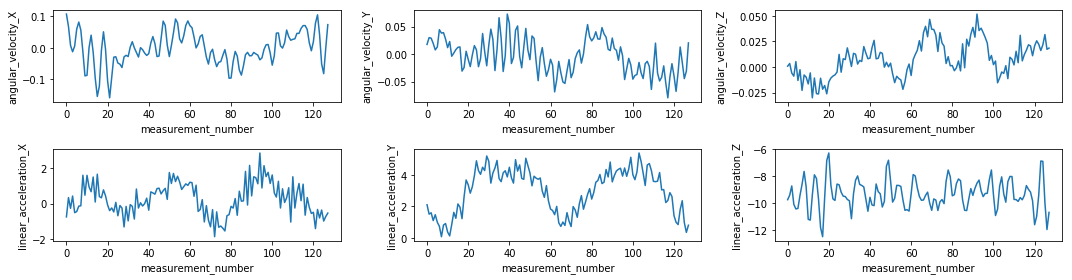

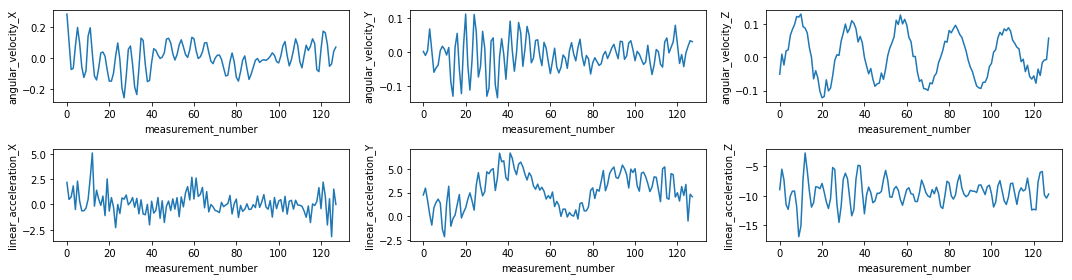

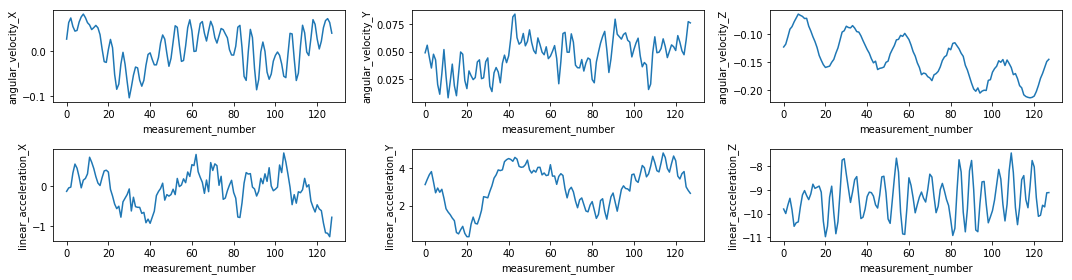

In [16]:
series_0_data=train_data[train_data['series_id']==0]
surface_type=train_labels['surface'][0]
print("Feature Variations for Surface Type {}".format(surface_type))
plot_feature_variations(series_0_data, 0 , surface_type)


series_1_data=train_data[train_data['series_id']==1]
surface_type=train_labels['surface'][1]
print("Feature Variations for Surface Type {}".format(surface_type))
plot_feature_variations(series_1_data, 1 , surface_type)

series_4_data=train_data[train_data['series_id']==4]
surface_type=train_labels['surface'][4]
print("Feature Variations for Surface Type {}".format(surface_type))
plot_feature_variations(series_4_data, 4 , surface_type)

The three sections of plots above show the velocity and acceleration data for three different series based on flooring type namely: fine_concrete, concrete, soft_tiles. One major observation from the above plots is that the time-series values have some inherent patterns and especially the 'angular_velocity_Z' seems to vary drastically with the flooring type.

To capture these variations in values across a series, we shall make use of multiple descriptive statistics features like mean, median, std, etc. and use them as features to train our classifier.

concrete                  779
soft_pvc                  732
wood                      607
tiled                     514
fine_concrete             363
hard_tiles_large_space    308
soft_tiles                297
carpet                    189
hard_tiles                 21
Name: surface, dtype: int64


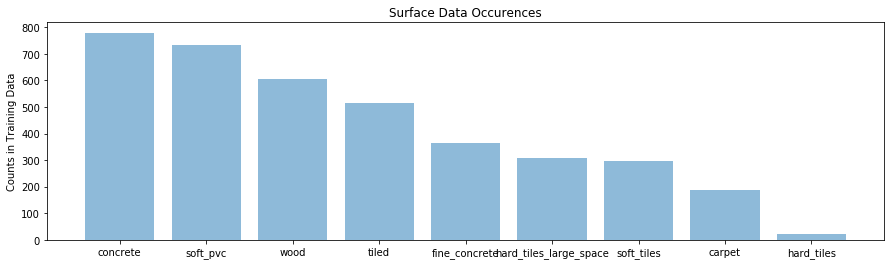

In [17]:
x = np.arange(9)
counts = train_labels['surface'].value_counts()
 
plt.figure(figsize=(15,4))
plt.bar(x, counts, align='center', alpha=0.5)
plt.xticks(x, train_labels['surface'].value_counts().index.tolist())
plt.ylabel('Counts in Training Data')
plt.title('Surface Data Occurences')

print(train_labels['surface'].value_counts())

y=train_labels['surface'].values

One key observation here is that the data is highly imbalanced with very less examples of hard_tiles in particular. So, this needs to be taken care of while splitting the data for cross-validation.

In [18]:
group_ids=train_labels['group_id']
print(group_ids.shape)
print(group_ids.nunique())

group_ids=np.array(group_ids)

(3810,)
73


The group_ids indicate the batches in which the training was conducted while recording the data. There are 73 such groups.

# Feature Extraction

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

In [20]:
train_features=train_data.drop(['row_id','measurement_number'],axis=1)

In [21]:
train_features.columns

Index(['series_id', 'orientation_X', 'orientation_Y', 'orientation_Z',
       'orientation_W', 'angular_velocity_X', 'angular_velocity_Y',
       'angular_velocity_Z', 'linear_acceleration_X', 'linear_acceleration_Y',
       'linear_acceleration_Z'],
      dtype='object')

In [22]:
sc= MinMaxScaler()

def feature_transform(features_data):
    all_features=pd.DataFrame()
    
    features_data['orientation']=np.sqrt(features_data['orientation_X']**2+features_data['orientation_Y']**2+
                                         features_data['orientation_Z']**2+features_data['orientation_W']**2)
    
    features_data['ang_vel_mag']=np.sqrt(features_data['angular_velocity_X']**2 + 
                                features_data['angular_velocity_Y']**2 + features_data['angular_velocity_Z']**2)
    
    features_data['lin_acc_mag']=np.sqrt(features_data['linear_acceleration_X']**2 + 
                                features_data['linear_acceleration_Y']**2 + features_data['linear_acceleration_Z']**2)
    
    
    for col in features_data.columns:
        if col=='series_id':
            continue
        all_features[col+'_mean']=features_data.groupby('series_id')[col].mean()
        all_features[col+'_median']=features_data.groupby('series_id')[col].median()
        all_features[col+'_min']=features_data.groupby('series_id')[col].min()
        all_features[col+'_max']=features_data.groupby('series_id')[col].max()
        all_features[col+'_std']=features_data.groupby('series_id')[col].std()
        #all_features[col+'_q25']=features_data.groupby('series_id')[col].quantile(0.25)
        #all_features[col+'_q50']=features_data.groupby('series_id')[col].quantile(0.5)
        #all_features[col+'_q75']=features_data.groupby('series_id')[col].quantile(0.75)
        all_features[col+'_maxByMin']=all_features[col+'_max']/all_features[col+'_min']
        all_features[col+'_range']=all_features[col+'_max']-all_features[col+'_min']
       
        
    all_features=all_features.reset_index()
    all_features=all_features.drop(['series_id'],axis=1)
    all_features=sc.fit_transform(all_features)
    
    return all_features

In [23]:
all_train_features=feature_transform(train_features)

In [24]:
enc = LabelEncoder()
y_transformed=enc.fit_transform(np.reshape(y,(-1,1)))

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
y_transformed[:25]

array([2, 1, 1, 1, 6, 7, 5, 1, 4, 7, 5, 7, 0, 0, 1, 0, 0, 6, 7, 6, 7, 4,
       6, 7, 6])

In [26]:
X=np.array(all_train_features)
y=y_transformed

# Model Evaluation

In [27]:
test_data= pd.read_csv("../input/X_test.csv")

In [28]:
test_data.shape

(488448, 13)

In [29]:
test_features=test_data.drop(['row_id','measurement_number'],axis=1)

In [30]:
all_test_features=feature_transform(test_features)

In [31]:
all_test_features=np.array(all_test_features)

print(len(all_test_features))
print(len(all_test_features[0]))

3816
91


In [32]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)
predicted = np.zeros((len(all_test_features),9))
measured= np.zeros(len(X))
score = 0

model = RandomForestClassifier(n_estimators=500, random_state=123, max_depth=15, min_samples_split=5)

for t, (trn_idx, val_idx) in enumerate(folds.split(X,y)):    
    model.fit(X[trn_idx],y[trn_idx])
    measured[val_idx] = model.predict(X[val_idx])
    predicted += model.predict_proba(all_test_features)/folds.n_splits
    score += model.score(X[val_idx],y[val_idx])
    print("Fold: {} score: {}".format(t,model.score(X[val_idx],y[val_idx])))

Fold: 0 score: 0.8420365535248042
Fold: 1 score: 0.865359477124183
Fold: 2 score: 0.8412073490813649
Fold: 3 score: 0.8447368421052631
Fold: 4 score: 0.8850726552179656


I have used StratifiedKFold validation as the classes are greatly imbaalanced in the training dataset.

In [33]:
print(confusion_matrix(measured,y))

[[145   6   0   0   5   4   4   6   4]
 [ 17 679  27   0  15  20   6  27  16]
 [  0   6 273   0   4   4   1   3   6]
 [  0   0   0  10   0   0   0   0   0]
 [  1  14   3   0 266   9   0   4   0]
 [  5  24  12   0   3 657  11   9  39]
 [  8   8   3   2   0  16 262   6   3]
 [  2  15  14   0   0   4   4 448  19]
 [ 11  27  31   9  15  18   9  11 520]]


In [34]:
print('Average Accuracy is ',score/folds.n_splits)

Average Accuracy is  0.855682575410716


# Submission File

In [37]:
submission_file=pd.read_csv("../input/sample_submission.csv")

In [38]:
results=pd.DataFrame(enc.inverse_transform(predicted.argmax(axis=1)))

In [39]:
results.head()

,0
0,hard_tiles_large_space
1,carpet
2,tiled
3,soft_tiles
4,soft_tiles


In [40]:
final_submission=submission_file.drop(['surface'],axis=1)

In [41]:
final_submission=pd.concat([final_submission,results],axis=1,ignore_index=True)

In [42]:
final_submission.to_csv("submission_final.csv",header=['series_id','surface'],index=False)

**By: Prabhat Kumar Sahu**